# 3 Transformer



## 3.1 Pytorch基础

### 3.1.1 张量逐元素相乘(*)

In [ ]:
import torch

#逐元素相乘
x = torch.tensor([[1, 2], [3, 4]])
y = torch.tensor([[2, 1], [4, 3]])
c = x * y
print(c)

tensor([[ 2,  2],
        [12, 12]])


Tensor可广播扩展
>在PyTorch或NumPy中，广播（broadcasting）指的是当两个张量（tensor）形状不完全相同时，自动扩展较小张量的维度以匹配较大张量，从而进行逐元素运算的机制。

In [ ]:
import torch

# 定义一个 (3, 3) 的矩阵
matrix = torch.tensor([[1, 2, 3],
                       [4, 5, 6],
                       [7, 8, 9]])

# 定义一个 3x1 的列向量
vector = torch.tensor([10, 20, 30]).view(3, 1)  # 形状 (3, 1)

# 执行逐元素乘法（广播会自动应用）
result = matrix * vector  # 或 torch.mul(matrix, vector)
print(result)

#此时vector相当于从(3, 1) -> (3, 3) 复制了3列 再 * matrixS

tensor([[ 10,  20,  30],
        [ 80, 100, 120],
        [210, 240, 270]])



## 3.2 理解Transformer
参考资料
* [最强动画讲解！目前B站最全最详细的Transformer教程](https://www.bilibili.com/video/BV1fGeAz6Eie/?p=10&share_source=copy_web&vd_source=c379ccdab784832c917bb852fa2b0584)

* 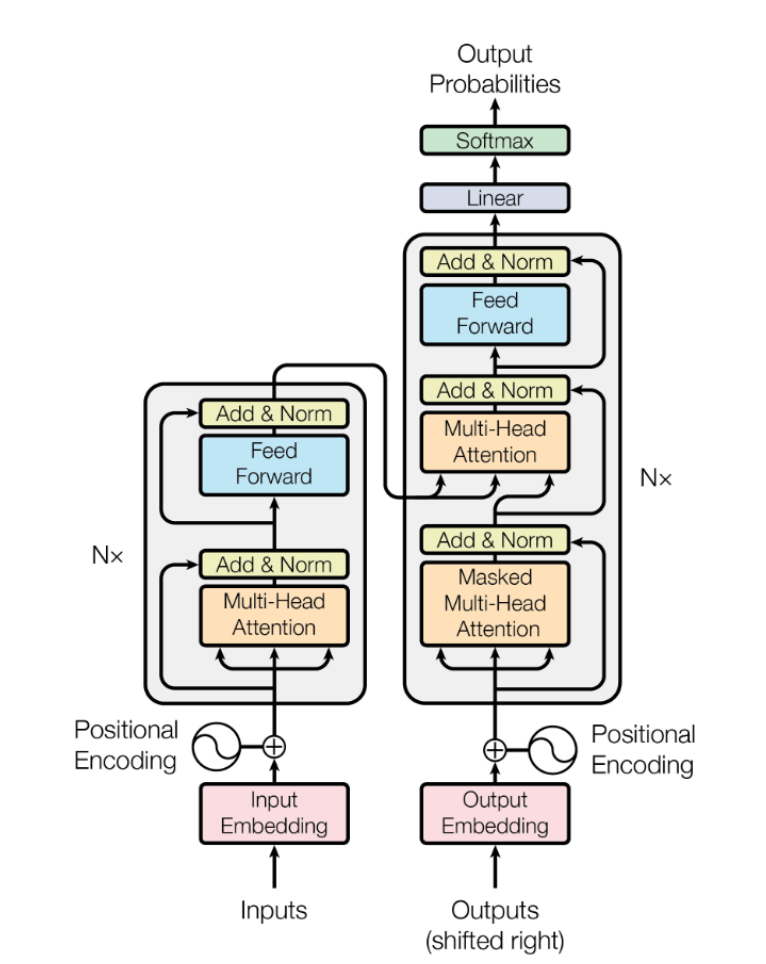


（1）输入部分

*    源文本嵌入层：将源文本中的词汇数字表示转换为向量表示，捕捉词汇间的关系。
*    位置编码层：为输入序列的每个位置生成位置向量，以便模型能够理解序列中的位置信息。
*    目标文本嵌入层（在解码器中使用）：将目标文本中的词汇数字表示转换为向量表示。

（2）编码器部分

*    由N个编码器层堆叠而成。
*    每个编码器层由两个子层连接结构组成：第一个子层是多头自注意力子层，第二个子层是一个前馈全连接子层。每个子层后都接有一个规范化层和一个残差连接。

（3）解码器部分

*    由N个解码器层堆叠而成。
*    每个解码器层由三个子层连接结构组成：第一个子层是一个带掩码的多头自注意力子层，第二个子层是一个多头注意力子层（编码器到解码器），第三个子层是一个前馈全连接层。每个子层后都接有一个规范化层和一个残差连接。

（4）输出部分

*    线性层：将解码器输出的向量转换为最终的输出维度。
*    Softmax层：将线性层的输出转换为概率分布，以便进行最终的预测。

## 3.3 基本构建模块：线性层和嵌入层
### 3.3.1 参数初始化(Xavier初始化)

* 线性层权重：$W_{ij}\sim\mathcal{N}(0,\sigma^2)$ 其中 $\sigma^2=\frac{2}{d_{in}+d_{out}}$ 并截断至$\pm 3\sigma$范围
* 嵌入层$\sigma=1$


### 3.3.2 线性模块(Linear Module)
执行线性变换(矩阵乘法)的模块(不包含偏置项)

$$y=Wx$$

注意，在pytorch中，运算是行向量优先，则上述变换可看作$y^T=x^TW^T$

In [ ]:
import torch
import torch.nn as nn

input_dim = 16384
hidden_dim = 32

w = nn.Parameter(torch.randn(input_dim, hidden_dim))
x = nn.Parameter(torch.randn(input_dim))  # 1*16384形状
print("x的形状：", x.shape, "  w的形状：", w.shape)
print(x @ w)

x的形状： torch.Size([16384])   w的形状： torch.Size([16384, 32])
tensor([ 112.9031,  -32.6962,  251.1876,   76.3291,  -96.8649,  -31.0559,
           4.3047,   79.3327,  -20.6343, -112.2671,  -61.0237, -100.2143,
          56.3217, -132.1212,  -53.8139,   67.2336,  -17.9672,   40.9714,
          -6.7919,  225.1043,  180.5824,  -31.7400,  -11.6574,   48.5670,
          69.9639,  213.9710,  286.0013,   -0.4462,   98.3826,   81.1809,
          28.5153, -143.2357], grad_fn=<SqueezeBackward4>)


In [ ]:

input_dim=16384
hidden_dim=32

w = nn.Parameter(torch.randn(input_dim,hidden_dim) / torch.sqrt(input_dim))
output = x @ w
print(output)

tensor([-1.3180, -0.8209,  2.5495,  0.5584,  0.9420,  1.4357, -1.1946,  1.1328,
         0.9352,  1.0427, -0.7384, -1.0063, -1.6775,  0.8776,  1.5028, -0.4387,
        -0.8161, -0.5544,  0.9419,  2.1187, -0.3722, -0.4222,  0.8345, -0.3200,
        -0.6286,  0.5852,  1.1251, -0.2014, -0.4105, -1.1395, -0.3861, -0.0554],
       grad_fn=<SqueezeBackward4>)


#### 实现线性模块：
交付内容：实现一个继承自 torch.nn.Module 的 Linear 类，执行线性变换。你的实现应遵循 PyTorch 内置的 nn.Linear 模块的接口，但不需要支持 bias（偏置）参数。

我们推荐以下接口：

`def __init__(self, in_features, out_features, device=None, dtype=None)`

构造一个线性变换模块。该函数应接受以下参数：

*    in_features: int，输入张量的最后一个维度大小
*    out_features: int，输出张量的最后一个维度大小
*    device: torch.device | None = None，用于存储参数的设备
*    dtype: torch.dtype | None = None，参数的数据类型

`def forward(self, x: torch.Tensor) -> torch.Tensor`

对输入 x 应用线性变换并返回结果。

注意事项：

*    必须继承 nn.Module
*    在 __init__ 中调用父类构造函数（即 super().__init__()）
*    创建并存储你的权重参数 W（注意：是 W 而不是 W⊤，出于内存布局的考虑），并将 W 包装为 nn.Parameter
*    不能使用 nn.Linear 或 nn.functional.linear
*    权重初始化：使用 torch.nn.init.trunc_normal_ 函数进行初始化


In [3]:
import torch
import torch.nn as nn
import numpy as np


class LinearModule(nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        device: torch.device | None = None,
        dtype: torch.dtype | None = None,
    ):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.device = device
        self.dtype = dtype

        # 当 nn.Parameter 被分配为 nn.Module 的属性时（通常在 __init__ 方法中），PyTorch 会自动将其注册到模型的 parameters() 列表中。
        # 优化器通过调用 model.parameters() 获取所有需要更新的参数，只有注册了的 nn.Parameter 才会被包含在内。

        # nn.Parameter 默认启用梯度计算（requires_grad=True），在反向传播时参与梯度计算和优化。
        self.W = nn.Parameter(
            torch.empty(
                self.in_features,
                self.out_features,
                device=self.device,
                dtype=self.dtype,
            )
        )
        self.bias = nn.Parameter(torch.zeros(self.output_features))

        # Xavier初始化使激活值的方差保持一致，避免梯度消失或爆炸
        std = np.sqrt(2 / (self.in_features + self.out_features))  # 标准差
        torch.nn.init.trunc_normal_(
            self.W, mean=0.0, std=std, a=-3 * std, b=3 * std
        )

    def forward(self, x):
        return x @ self.W + self.bias

### 3.3.3 嵌入模块(Embedding Module)
Transformer 的第一层是一个嵌入层（embedding layer），它将整数形式的 token ID 映射到维度为 d_model 的向量空间。

我们将实现一个自定义的 Embedding 类，该类继承自 torch.nn.Module（因此你不应使用 nn.Embedding）。

其 forward 方法应通过在一个形状为（vocab_size, d_model）的嵌入矩阵中，使用形状为（batch_size, sequence_length）的 torch.LongTensor 类型的 token ID 进行索引，来为每个 token ID 选择对应的嵌入向量。

* [例子]( https://www.bilibili.com/video/BV1bxRpYdEbT/?p=3&share_source=copy_web&vd_source=c379ccdab784832c917bb852fa2b0584)
* 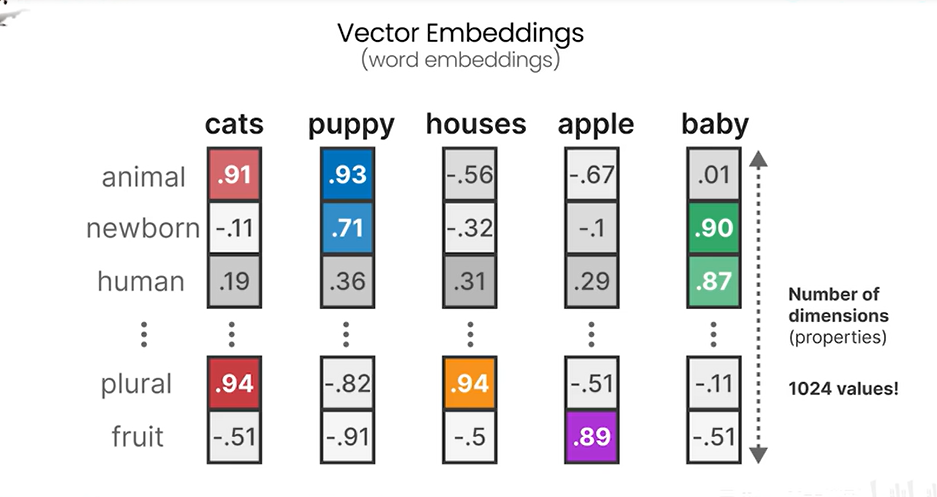


#### 实现嵌入模块：
交付内容：实现一个名为 Embedding 的类，该类继承自 torch.nn.Module，并执行嵌入查找操作。你的实现应当遵循 PyTorch 内置的 nn.Embedding 模块的接口。我们推荐使用以下接口：

`def __init__(self, num_embeddings, embedding_dim, device=None, dtype=None)`

构造一个嵌入模块。该函数应接受以下参数：

*    num_embeddings: int，词汇表的大小
*    embedding_dim: int，嵌入向量的维度，即 d_model
*    device: torch.device | None = None，参数存储的设备
*    dtype: torch.dtype | None = None，参数的数据类型

`def forward(self, token_ids: torch.Tensor) -> torch.Tensor`

对给定的 token ID 查找对应的嵌入向量。

注意事项：

*    必须继承 nn.Module 类
*    必须调用父类（超类）的构造函数
*    将嵌入矩阵初始化为 nn.Parameter
*    嵌入矩阵的形状应为 (num_embeddings, embedding_dim)，即 embedding_dim 是最后一个维度
*    不能使用 nn.Embedding 或 nn.functional.embedding
*    权重初始化请使用 torch.nn.init.trunc_normal_（截断正态分布初始化），并使用上述推荐的参数设置

In [ ]:
import torch
import torch.nn as nn
import numpy as np


class EmbeddingModule(nn.Module):

    def __init__(
        self,
        num_embeddings: int,
        embedding_dim: int,
        device: torch.device | None = None,
        dtype: torch.dtype | None = None,
    ):
        super().__init__()
        # 保存词汇表大小和嵌入向量维度
        self.num_embeddings = num_embeddings  # 词汇表大小（vocab size）
        self.embedding_dim = embedding_dim  # 每个词向量的维度（d_model）
        self.device = device  # 参数存储的设备（如 CPU/GPU）
        self.dtype = dtype  # 参数的数据类型（如 float32）

        # 初始化嵌入矩阵：形状为 (num_embeddings, embedding_dim)
        # 使用 nn.Parameter 包装，使其成为可学习参数
        self.embedding_matrix = nn.Parameter(
            torch.empty(
                self.num_embeddings, self.embedding_dim, device=device, dtype=dtype
            )
        )

        # 使用截断正态分布初始化参数，均值为0，标准差为1，截断范围为 [-3, 3]
        std = 1
        torch.nn.init.trunc_normal_(
            self.embedding_matrix, std=std, a=-3.0 * std, b=3.0 * std
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # 使用索引 x 从嵌入矩阵中获取对应的嵌入向量
        return self.embedding_matrix[x]  # x 的形状为 (batch_size, seq_length)

## 3.4 预归一化 Transformer 模块（Pre-Norm Transformer Block）
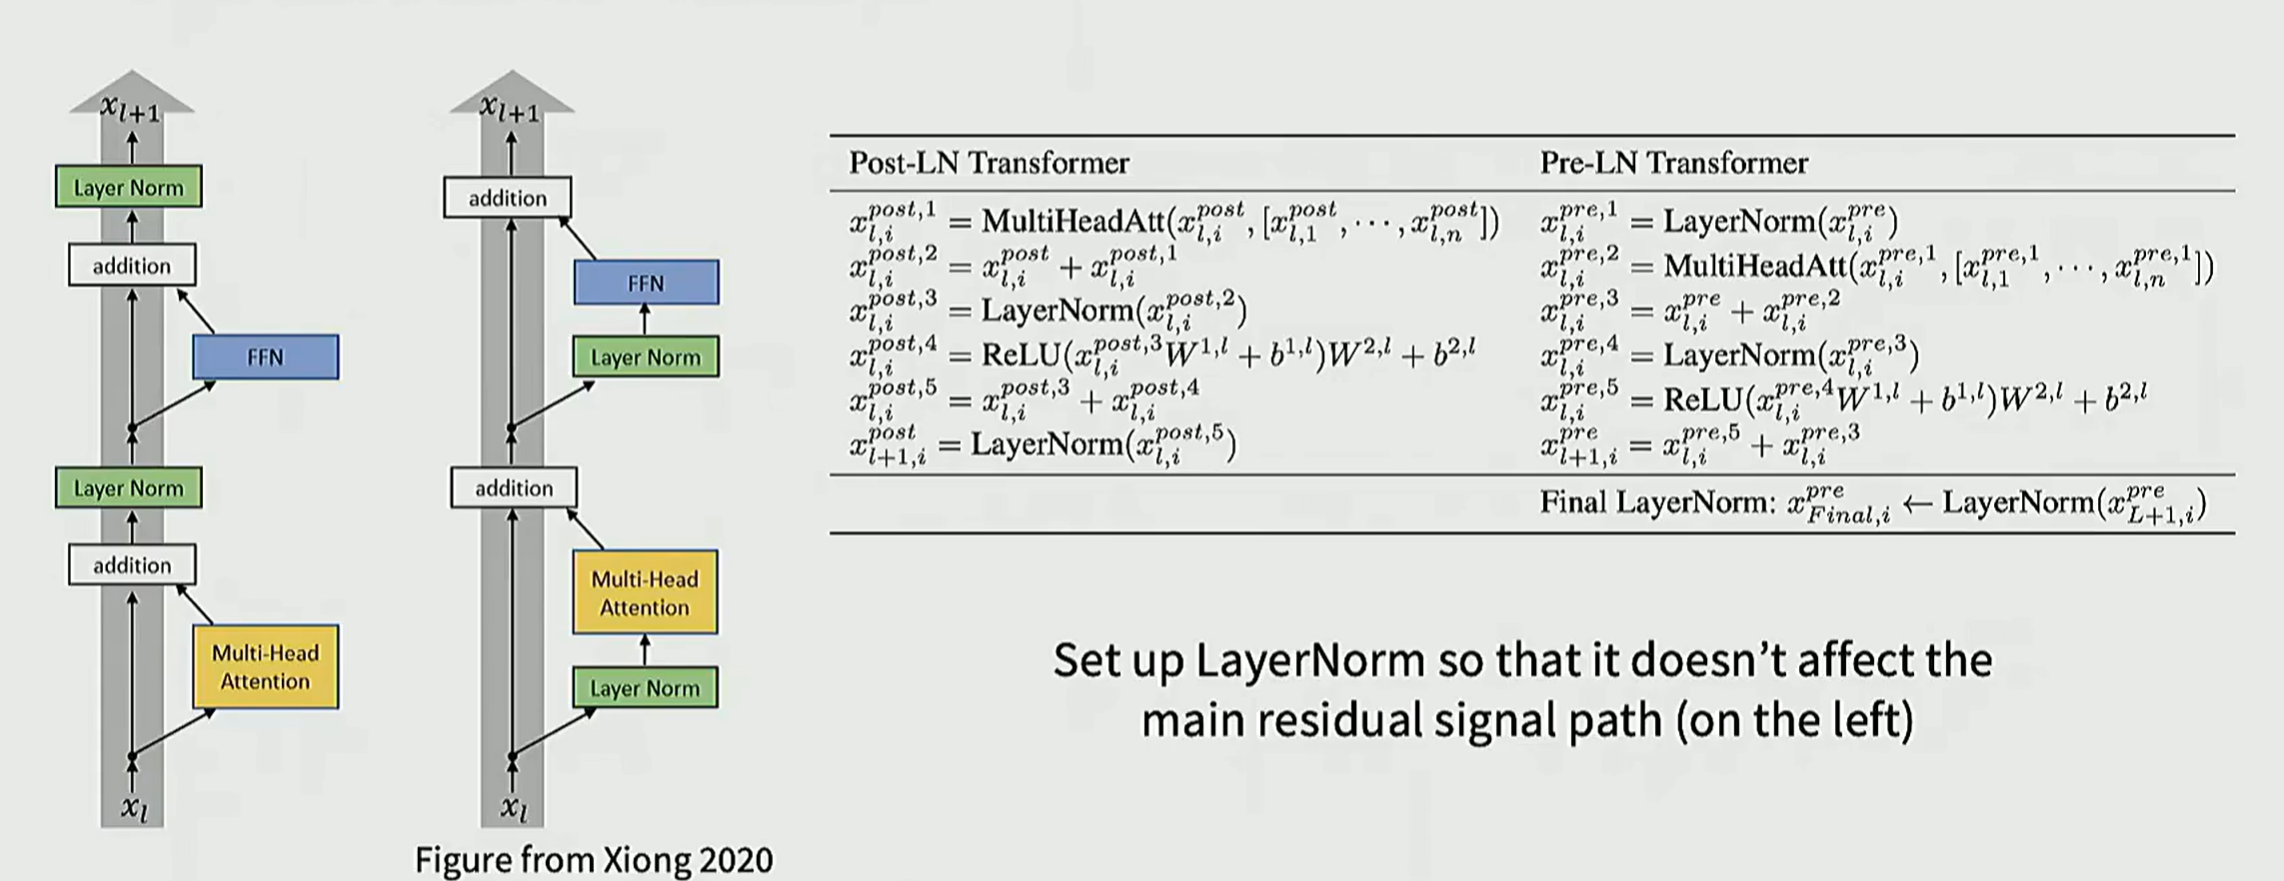


每个 Transformer 模块包含两个子层：
* (1) 多头自注意力机制（Multi-Head Self-Attention）
* (2) 位置级前馈网络（Position-wise Feed-Forward Network **FFN**）。

我们采用预归一化（pre-norm）结构：在每个子层之前先进行层归一化。具体来说，若模块输入为 $x$，输出为$z$，则模块执行如下操作：

* 自注意力子层：$$y=x+MultiHeadSelfAttention(RMSNorm(x))$$ 
* 前馈网络子层：$$z=y+FFN(RMSNorm(y))$$

每个残差连接后进入下一个子层。这种预归一化结构（配合 RMSNorm）在深层 Transformer 中有助于提升训练稳定性。

  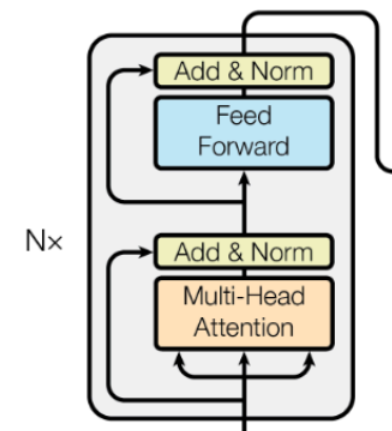

### 3.4.1 均方根归一化（Root Mean Square Layer Normalization **RMSNorm**）
给定输入向量 $\alpha \in \mathbb{R}^{d_{\text{model}}}$ 其中 $\alpha_i$ 为输入语句的第 $i$ 个 token (每个token 维度为 d_model )


$$\text{RMSNorm}(\alpha_i)=\frac{\alpha_i}{\text{RMS}(\alpha)}\cdot g_i$$
其中$\text{RMS}(\alpha)$是均方根
$$\text{RMS}(\alpha)=\sqrt{\frac{1}{d_{model}} \displaystyle \sum_{j=1}^{d_{model}} \alpha^2_{j} +\epsilon }$$
其中$g_i$是可学习的缩放参数(初始化为1)，$\epsilon$（例如1e-5）用于防止除零错误。

在实现时，应先将输入提升为 float32 类型再进行平方运算，以避免上溢，之后再降回原始数据类型。

例如：

In [ ]:
def f():
    # 前向传播中的示例框架    
    in_dtype = x.dtype    
    x = x.to(torch.float32)    
    # 执行 RMSNorm（省略具体计算）    
    # ...       
    result = ...    
    # 将结果转换回原始数据类型    
    return result.to(in_dtype)

为什么要使用**RMSNorm**?
* 最重要的是稳定训练过程，保证梯度传播的有效性。
* 相较于**LayerNorm**归一化 更加高效

#### 实现归一化模块
交付内容：将 RMSNorm 实现为一个 torch.nn.Module。

我们推荐使用以下接口：

`def __init__(self, d_model: int, eps: float = 1e-5, device=None, dtype=None)`

构造 RMSNorm 模块。该函数应接受以下参数：

*   d_model: int — 模型的隐藏层维度
*    eps: float = 1e-5 — 数值稳定用的 epsilon 值
*    device: torch.device | None = None — 参数存储的设备
*    dtype: torch.dtype | None = None — 参数的数据类型

`def forward(self, x: torch.Tensor) -> torch.Tensor`

处理一个形状为 (batch_size, sequence_length, d_model) 的输入张量，并返回相同形状的张量。

注意：如上所述，在执行归一化之前，请记得先将输入提升（upcast）为 torch.float32 类型（之后再降回原始数据类型）。

In [ ]:
import torch
from torch import nn


class RMSNorm(nn.Module):
    """
    Root Mean Square Layer Normalization (RMSNorm) 模块。

    RMSNorm 是一种轻量化的归一化方法，通过输入张量在特征维度上的均方根（RMS）进行归一化。
    与 LayerNorm 不同，RMSNorm 不减去均值，只除以 RMS 值，从而减少计算开销。
    归一化后，使用可学习的权重参数对每个特征通道进行缩放。

    参考论文: https://arxiv.org/abs/1910.07467
    """

    def __init__(
        self,
        d_model: int,
        eps: float = 1e-5,
        device: torch.device | None = None,
        dtype: torch.dtype | None = None,
    ):
        super().__init__()

        self.eps = eps  # 保存 epsilon 值，用于归一化中的数值稳定

        # 创建可学习的缩放权重参数，形状为 (d_model,)，初始化为全 1
        # 每个特征维度有一个对应的缩放因子
        self.weight = nn.Parameter(torch.ones(d_model, device=device, dtype=dtype))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        重写前向传播函数。
        
        对输入张量 x 进行 RMSNorm 归一化，然后用可学习的权重进行缩放。

        Args:
            x (torch.Tensor): 输入张量，形状为 (batch_size, sequence_length, d_model) sequence_length表示输入语句中token(位置)的数量
        Returns:
            torch.Tensor: 输出张量，形状与输入相同，但经过归一化和缩放
        """
        input_dtype = x.dtype
        x = x.to(torch.float32)

        # 计算最后一个维度（特征维度）上的均方值（即方差，但不减均值）
        # shape: (batch_size, sequence_length, 1)
        variance = x.pow(2).mean(-1, keepdim=True)

        # 使用均方根（RMS）进行归一化：x / sqrt(variance + eps)
        # torch.rsqrt 是 1 / sqrt(x) 的高效实现
        x = x * torch.rsqrt(variance + self.eps)

        # 将归一化后的结果与可学习的权重相乘（逐通道缩放）
        # 权重会自动广播到 batch , sequence 维度
        x = self.weight * x

        # 将结果转换回原始输入的数据类型（例如从 float32 回 float16）
        return x.to(input_dtype)

### 3.4.2 位置级前馈网络（Position-Wise Feed-Forward Network）


>在原始的Transformer论文（Vaswani等人[2017]，第3.3节）中，Transformer的前馈网络（Feed-Forward Network, FFN）由两个线性变换组成，中间使用ReLU激活函数（ReLU(x) = max(0, x)）。通常情况下，内部前馈层的维度是输入维度的4倍。
>
>然而，现代语言模型相较于这一原始设计引入了两个主要变化：使用了不同的激活函数，并采用了门控机制。具体来说，我们将实现一种名为“SwiGLU”的激活函数，该函数已被诸如Llama 3 [Grattafiori et al., 2024] 和 Qwen 2.5 [Yang et al., 2024] 等大语言模型（LLM）所采用。SwiGLU结合了SiLU（常被称为Swish）激活函数和一种称为门控线性单元（Gated Linear Unit, GLU）的门控机制。此外，我们还将省略线性层中有时使用的偏置项（bias），这是自PaLM [Chowdhery et al., 2022] 和 LLaMA [Touvron et al., 2023] 以来大多数现代大语言模型的做法。


SiLU（或称Swish）激活函数定义如下：
$$\text{SiLU}(x)=x\cdot \sigma (x)=\frac{x}{1+e^{-x}}$$

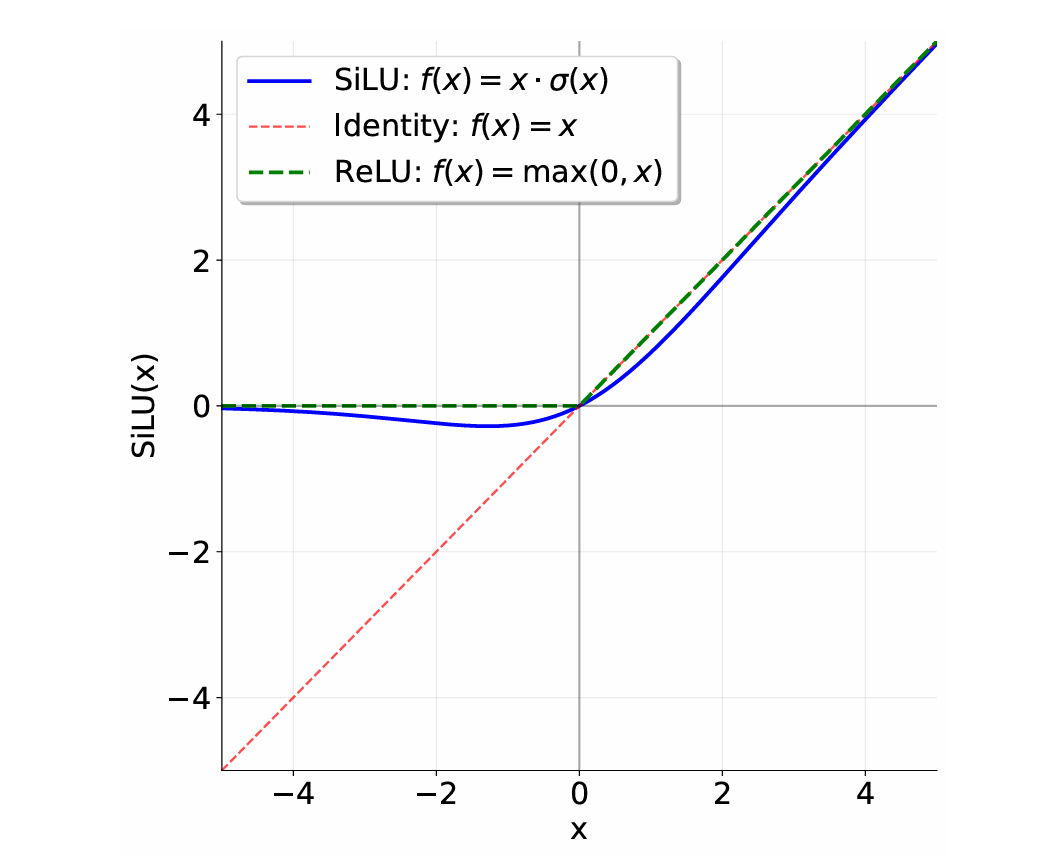




门控线性单元（GLU）最初由Dauphin等人[2017]提出，其定义为一个经过Sigmoid函数变换的线性变换与另一个线性变换之间的逐元素乘积：
$$\text{GLU}(x,W1​,W2​)=\sigma(W_1​x)⊙W_2​x$$

其中 $⊙$ 表示逐元素相乘。

门控线性单元被认为可以通过提供一条线性的梯度通路，同时保留非线性能力，从而“减轻深层架构中的梯度消失问题”。

将 SiLU/Swish 激活函数与 GLU 机制结合起来，就得到了 SwiGLU，我们将用它来构建前馈网络：
$$\text{FFN}(x)=\text{SwiGLU}(x,W_1,W_2,W_3)=W_2(\text{SiLU}(W_1x)⊙W_3x)$$

其中

$x \in \mathbb{R}^{d_{\text{model}}},$

$W_1,W_3 \in \mathbb{R}^{d_{\text{ff}}\times d_{\text{model}}},$

$W_2 \in \mathbb{R}^{d_{\text{model}}\times d_{\text{ff}}},$

通常设 $d_{\text{ff}}=\frac{8}{3} d_{\text{model}}$

#### 实现位置级前馈网络

交付内容：实现 SwiGLU 前馈网络，该网络由 SiLU 激活函数和门控线性单元（GLU）机制组成。

注意：在本题中，出于数值稳定性的考虑，你可以在实现中自由使用 torch.sigmoid。

在实现时，应将前馈层的隐藏维度 设置为大约 ，同时确保该维度是 64 的倍数，以便更好地利用硬件计算资源（如 GPU 的并行计算能力）。

In [ ]:
import torch
import torch.nn as nn

class SwiGLU(nn.Module):
    """SwiGLU 激活函数实现：FFN = W2 * (SiLU(W1 x) ⊙ W3 x)"""
    
    def __init__(self, d_model, d_ff):
        super().__init__()
        #直接用torch库中的Linear层
        self.w1 = nn.Linear(d_model, d_ff, bias=False)  # 升维到隐藏层
        self.w2 = nn.Linear(d_ff, d_model, bias=False)  # 降维回模型维度
        self.w3 = nn.Linear(d_model, d_ff, bias=False)  # 门控分支

    def forward(self, x):
        # SwiGLU: W2(SiLU(W1 x) ⊙ W3 x)
        #TODO: self.w1() 是nn.Module 实现的 __call__() 方法（自动调用forward），在本项目中可以复现到刚刚的线性层中
        return self.w2(self.w1(x).silu() * self.w3(x))
    
    



### 3.4.3 旋转位置编码(RoPE)
为了确定前后语句token之间的关系，通常在词嵌入后需要把位置编码加入到词向量

[通俗易懂-大模型的关键技术之一：旋转位置编码rope （1）](https://www.bilibili.com/video/BV12x42127Pb/?share_source=copy_web&vd_source=c379ccdab784832c917bb852fa2b0584)

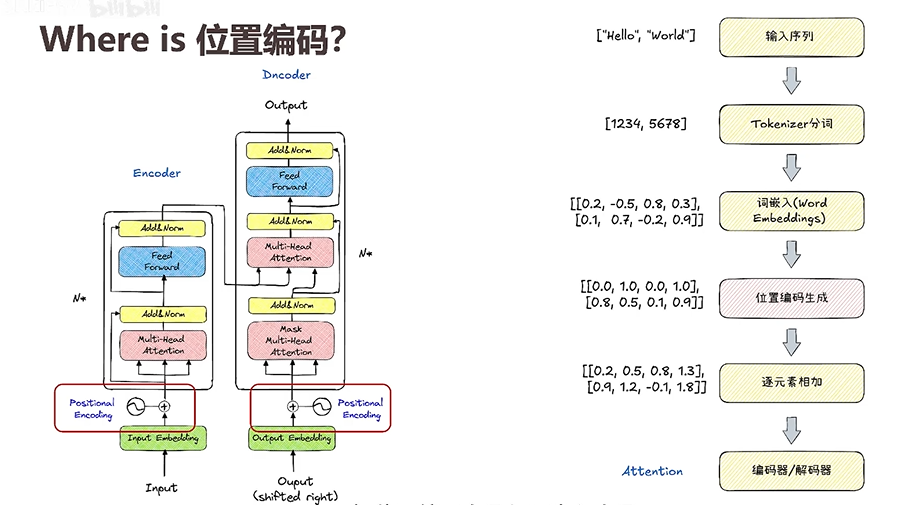

>TODO:比较一下和正弦位置编码的优势

为了克服原先嵌入层位置无关的特性，现在加入位置编码 $f(x_i,i)$

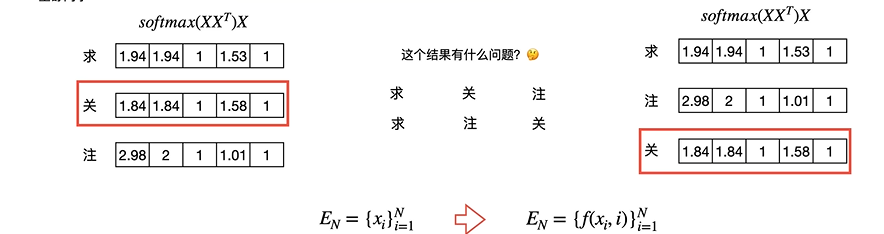

RoPE可描述为：
$$\left \langle f_q(x_m,m) , f_k(x_n,n)  \right \rangle = g(x_m,x_n,m-n)$$

其中$W_q,W_k$是注意力变换矩阵，后续会说明。

对于每个位置 $p$ 其词向量维度为 $d$ ，我们对每对维度 $(2k-1，2k)$ 施加一个角度为 $\theta_{p,k}$ 的旋转。

令$k=1,2 \cdots ,d/2$ ，定义：

$$\theta_{p,k}=p \cdot \frac{\Theta}{10000^{2k/d}}$$
其中 $\Theta$ 是常数。

对于第 $p$ 个token，每对维度 $(2k-1,2k)$ 的旋转矩阵:

$$R_{p,k}=\begin{bmatrix}  
  \cos(\theta_{p,k}) & -\sin(\theta_{p,k})  \\  
  \sin(\theta_{p,k}) & \cos(\theta_{p,k}) \\  
\end{bmatrix} $$


所有这些 $2 \times 2$ 块构成一个完整的 $d \times d$ 分块对角旋转矩阵 $R_p$ 。我们将 $R_p$ 应用于查询（Q）或键（K）向量（不作用于值向量 V）。实践中，我们可以通过预先计算正弦/余弦表（注册为 buffer，而非参数）来实现 RoPE，表的大小为 $(\text{max\_seq\_len},d)$ 。

前向传播时，根据实际序列长度切片对应的 sin/cos 值并应用。相同的旋转在所有注意力头之间共享（将头维度视为旋转的批处理维度）。

下图中$\cos(m\theta)=\theta_{m,1}$
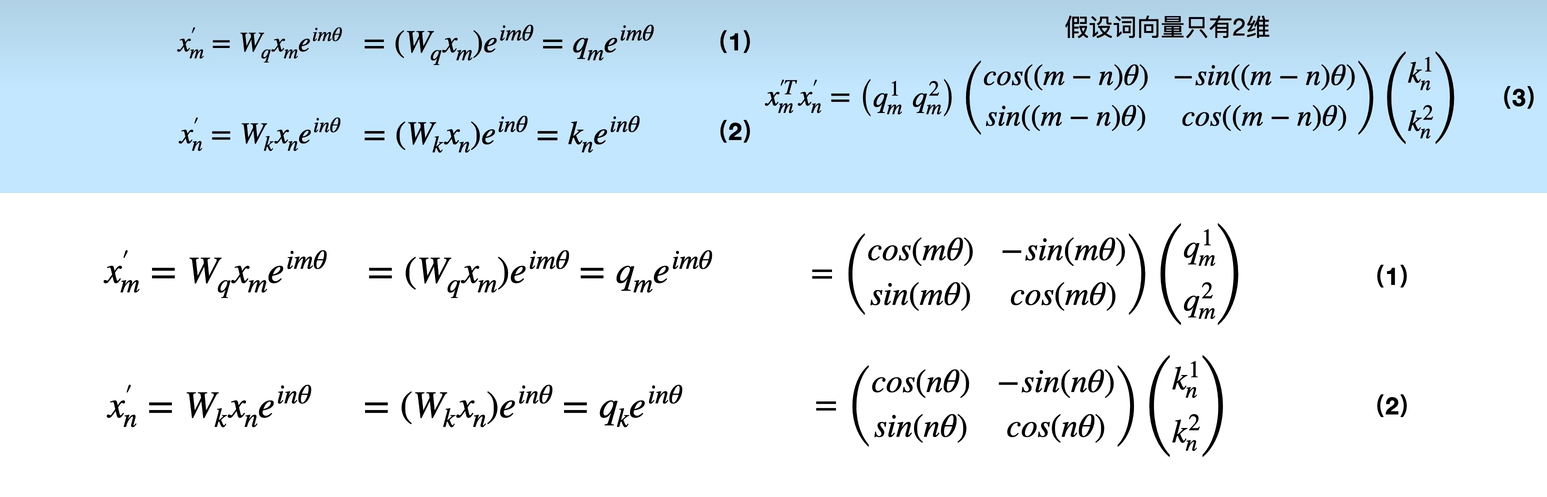

将旋转矩阵扩展到$d$ 维：

$$R_p=\begin{bmatrix}  
   R_{p,1}&   \\  
   & R_{p,2} \\
  &&\ddots\\
&&&&R_{p,d/2}
\end{bmatrix} 
=\begin{bmatrix}  
  \cos(\theta_{p,1}) & -\sin(\theta_{p,1})  \\  
  \sin(\theta_{p,1}) & \cos(\theta_{p,1}) \\  
  &&\cos(\theta_{p,2}) & -\sin(\theta_{p,2})  \\  
  &&\sin(\theta_{p,2}) & \cos(\theta_{p,2}) \\
&&&&\ddots\\
  &&&&&&\cos(\theta_{p,d/2}) & -\sin(\theta_{p,d/2})  \\
  &&&&&&\sin(\theta_{p,d/2}) & \cos(\theta_{p,d/2}) \\
\end{bmatrix} 
$$


#### 实现 RoPE

交付内容：实现一个名为 RotaryPositionalEmbedding 的类，将 RoPE（旋转位置编码）应用到输入张量上。

推荐的接口如下：

`def __init__(self, theta: float, d_k: int, max_seq_len: int, device=None)`

*    构造 RoPE 模块，并在需要时创建缓存（buffers）。
*    theta: RoPE 中的 Θ 值（控制旋转角度的频率基底）。
*    d_k: 查询（query）和键（key）向量的维度。
*    max_seq_len: 输入序列的最大长度。
*    device: 存储缓存张量的设备（torch.device 或 None）。

`def forward(self, x: torch.Tensor, token_positions: torch.Tensor) -> torch.Tensor`

*    处理形状为 (..., seq_len, d_k) 的输入张量 x，返回相同形状的输出张量。
*    应支持任意数量的批处理维度（batch dimensions）。
*    假设 token_positions 是一个形状为 (..., seq_len) 的张量，表示 x 在序列维度上的各个 token 的位置索引。
*    你应该使用 token_positions 来从预先计算好的 cos 和 sin 张量中沿序列维度进行索引（切片）。

In [ ]:
import torch
import torch.nn as nn

class RoPE(nn.Module):
    """
    Rotary Positional Embedding (RoPE): 通过旋转方式将位置信息注入 query 和 key 向量。
    
    公式：
        rope(x) = x[:, 2i]   * cos(pos * θ^(-2i/d_k)) 
                - x[:, 2i+1] * sin(pos * θ^(-2i/d_k))

    支持任意批处理维度，并根据 token_positions 动态索引预计算的 cos/sin 缓存。
    """
    def __init__(self, theta: float, d_k: int, max_seq_len: int,device: torch.device | None = None,):
        super().__init__()        
        if d_k % 2 != 0:
            raise ValueError("d_k must be even for RoPE")

        self.theta = theta
        self.d_k = d_k
        self.max_seq_len = max_seq_len
        self.device = device

        # 计算频率基: 1 / θ^(2p/d_k)
        freqs = 1.0 / (theta ** (torch.arange(0, d_k, 2).float() / d_k))  # shape: [d_k//2]

        # 生成所有位置的旋转角度: [max_seq_len, d_k//2]
        positions = torch.arange(max_seq_len, device=device)
        sinusoids = torch.outer(positions, freqs)  # 外积，扩展为 [max_seq_len, d_k//2]

        # 缓存 cos 和 sin 编码，不参与训练
        self.register_buffer("cos_cache", sinusoids.cos(), persistent=False)
        self.register_buffer("sin_cache", sinusoids.sin(), persistent=False)

    def forward(self, x: torch.Tensor, token_positions: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: shape (*, seq_len, d_k), 输入张量（支持任意批维度）
            token_positions: shape (*, seq_len), 每个 token 的绝对位置索引

        Returns:
            shape (*, seq_len, d_k), 应用旋转编码后的输出
        """
        # 从缓存中取出对应位置的 cos 和 sin: shape (*, seq_len, d_k//2)
        cos = self.cos_cache[token_positions]
        sin = self.sin_cache[token_positions]

        # 分割输入为偶数和奇数维度: x = [x_even, x_odd]
        x_even = x[..., 0::2]  # 偶数索引: 0, 2, 4, ...
        x_odd  = x[..., 1::2]  # 奇数索引: 1, 3, 5, ...

        # 应用旋转公式(注意下标从0开始)
        out_even = x_even * cos - x_odd * sin
        out_odd  = x_even * sin + x_odd * cos

        # 交错合并: 将 (even, odd) 沿最后一维堆叠并展平
        out = torch.stack([out_even, out_odd], dim=-1)  # shape: (*, seq_len, d_k//2, 2)
        out = out.flatten(-2)  # shape: (*, seq_len, d_k)

        return out

### 3.4.4 缩放点积注意力（Scaled Dot-Product Attention）

我们现在可以将注意力（Attention）操作从数学上定义如下：

$$\text{Attention}(Q,K,V)=\text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$$
其中，$Q \in \mathbb{R}^{n \times d_k},K \in \mathbb{R}^{m \times d_k},V \in \mathbb{R}^{m \times d_v}$

$Q,K,V$ 分别表示初始词向量与权重参数$W_q,W_k,W_v$作线性变换后的结果，
$d_k$ 表示输入词向量维度。

* Q（Query，查询）‌：代表当前需要关注其他位置信息的“提问者”。它用于与所有位置的键（Key）计算相似度，从而确定哪些位置的信息需要被关注。
* K（Key，键）‌：类似于“索引”，用于与查询（Query）匹配，计算注意力权重。键和查询的相似性决定了其他位置对当前位置的重要性。
* V（Value，值）‌：表示“信息的内容”，它携带的是特征的信息。在下图中可以看到，编码器训练的 $Q,K$ 参数传入了解码器，最后和解码层的 $V$ 相乘

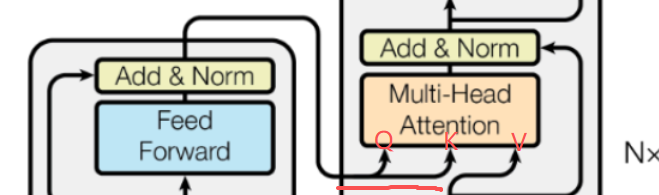

[【Transformer】最强动画讲解！]( https://www.bilibili.com/video/BV1fGeAz6Eie/?p=6&share_source=copy_web&vd_source=c379ccdab784832c917bb852fa2b0584)

#### 掩码(Masking)
有时我们希望对注意力操作的输出进行掩码处理，比如解码器的注意力子层，在模型训练时模拟真实推理的情形（看不到后文结果）。
掩码的矩阵的形式为：
$$M \in  \{\text{True},\text{False}\}^{n \times m}$$

$M_{ij}=\text{True}$ 表示位置 $i$ 可以查询位置 $j$ ，否则不可以查询。

从计算角度看，使用掩码比在子序列上单独计算注意力更高效。我们可以通过在 softmax 前的注意力分数矩阵 $\frac{QK^T}{\sqrt{d_k}}$ 上，将掩码为 False 的位置加上 来实现这一效果（实际实现中通常用极小的负数如 -1e9 代替 ）。这样，softmax 会将这些位置的权重置为接近零，从而屏蔽对应的信息流动。

#### 实现softmnax

给定一个输入向量 $Z=[z_1,z_2,\cdots,z_n] \in \mathbb{R}^n $，Softmax 函数的第 $i$ 个输出定义为：

$$\text{softmax}(Z)_i=\frac{e^{z_i}}{ {\textstyle \sum_{j=1}^{n}}  e^{z_j}}$$

* 分子‌：对第 $i$ 个元素进行指数变换，放大其相对大小；
* 分母‌：对所有元素的指数求和，实现全局归一化；
* 输出结果满足：$\sum_{i=1}^{n}\text{softmax}(Z_i)=1$，且每个值 $\in(0,1)$。


交付内容：编写一个函数，对张量执行 softmax 操作。你的函数应接受两个参数：一个张量和一个维度 i，并在输入张量的第 i 维上应用 softmax。输出张量应与输入张量具有相同的形状，但其第 i 维将变为归一化的概率分布。

为了防止数值不稳定问题，你需要使用 **“减去最大值”** 的技巧：在对第 i 维进行指数运算前，先从该维的每个元素中减去该维的最大值。



In [ ]:
import torch

def softmax(x: torch.Tensor, dim: int) -> torch.Tensor:
    """
    在指定维度上执行数值稳定的 softmax。
    公式: exp(x - max(x)) / sum(exp(x - max(x)))
    """
    x_max = x.max(dim=dim, keepdim=True)[0]
    x_exp = torch.exp(x - x_max)
    return x_exp / x_exp.sum(dim=dim, keepdim=True) 


#### 实现缩放点积注意力（scaled_dot_product_attention）
交付内容：实现缩放点积注意力函数。

你的实现应支持形状为 (batch_size, ..., seq_len, d_k) 的查询 $Q$ 和键（K），以及形状为 (batch_size, ..., seq_len, d_v) 的值（V），其中 ... 表示任意数量的批处理类维度（如果存在）。

函数应返回形状为 (batch_size, ..., d_v) 的输出。
> 关于批处理类维度的讨论，详见第 3.3 节。

你的实现还应支持一个可选的、用户提供的布尔类型掩码（mask），其形状为 (seq_len, seq_len)。

对于掩码值为 True 的位置，其对应的注意力概率应正常计算并归一化（总和为 1）；而对于掩码值为 False 的位置，其注意力概率应为 0（即被屏蔽）。

In [ ]:
import torch
from torch import nn

class ScaledDotProductAttention(nn.Module):
    """
    缩放点积注意力模块：计算 Attention(Q, K, V) = softmax(QK^T / √d_k) V
    支持多维批处理和可选掩码。
    """

    def __init__(self):
        super().__init__()

    def forward(self, Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor, mask: torch.Tensor | None = None):
        """
        前向传播。

        Args:
            Q: 查询张量，shape (*, seq_len_q, d_k)
            K: 键张量，shape (*, seq_len_kv, d_k)
            V: 值张量，shape (*, seq_len_kv, d_v)
            mask: 布尔掩码，shape (seq_len_q, seq_len_kv) 或可广播形状，True 表示保留

        Returns:
            输出张量，shape (*, seq_len_q, d_v)
        """
        d_k = Q.shape[-1]
        # 计算缩放后的注意力分数
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (d_k ** 0.5)

        # 应用掩码（如有）
        if mask is not None:
            scores = scores.masked_fill(~mask, -1e9)  # ~mask 将 True→False，屏蔽位置

        # 归一化注意力权重并加权求和
        attn_weights = torch.softmax(scores, dim=-1)
        return torch.matmul(attn_weights, V)

### 3.4.5 因果多头自注意力（Causal Multi-Head Self-Attention）

$$\text{MultiHead}(Q,K,V)=\text{Concat}(head_1,\cdots,head_h)$$
其中
$$head_i=\text{Attention}(Q_i,K_i,V_i)$$
$Q_i,K_i,V_i $ 分别是 $Q,K,V$ 在嵌入维度上的第 $i$ 个切片，每切片大小分别为$d_k,d_v$

多头注意力表达形式如下：
$$\text{MultiHeadSelfAttention}(x)=W_O \cdot \text{MultiHead}(W_Qx,W_Kx,W_Vx)$$

可以学习的参数：
* $W_Q \in \mathbb{R}^{hd_k \times d_{\text{model}}}$
* $W_K \in \mathbb{R}^{hd_k \times d_{\text{model}}}$
* $W_V \in \mathbb{R}^{hd_v \times d_{\text{model}}}$
* $W_O \in \mathbb{R}^{ d_{\text{model}} \times hd_k}$

$W_O$ 是多头自注意力机制的‌输出投影矩阵‌，用于将多个注意力头的输出结果合并并映射到目标维度。        

> 拓展目标（可选）：尝试将键、查询和值的投影合并为一个单一的权重矩阵，从而只需一次矩阵乘法即可完成全部投影。

#### 因果掩码（Causal Masking）
你的实现应防止模型关注序列中的未来 token。因为在推理生成文本时，模型无法提前看到未来的 token；若允许访问，会泄露真实下一个词的信息，从而让语言建模任务变得平凡。

最朴素的方法是对序列的每一个前缀单独运行一次注意力（共 $n$ 次），但我们采用**因果注意力掩码**来高效解决这个问题：它允许位置 $i$ 只关注所有满足 $j \leq i$ 的位置 $j$。
你可以使用 torch.triu 或广播的索引比较来构造这样的上三角掩码（上三角部分为 False），并利用你在 §3.4.5 中实现的缩放点积注意力已支持掩码这一特性。

#### 应用 RoPE（旋转位置编码）
RoPE 应仅应用于**查询（Q）和键（K）向量，不应用于值（V）向量**。此外，在处理多头结构时，头维度应被视为批处理维度，因为每个注意力头是独立计算注意力的。这意味着相同的 RoPE 旋转操作应分别应用于每个头的查询和键向量——即对每个头独立地应用相同的位置旋转方式（共享旋转频率，但按头独立作用于其对应的 Q 和 K）。

#### 实现因果多头自注意力
交付内容：将因果多头自注意力实现为一个 torch.nn.Module 模块。你的实现应至少接受以下参数：

* d_model: int，Transformer 模块输入的特征维度。
* num_heads: int，多头自注意力中使用的注意力头数量。

按照 Vaswani 等人 [2017] 的设定，令每个头的键 $d_k$ 和值 $d_v$ 的维度为：
$$d_k=d_v=\frac{d_{\text{model}}}{h}$$


你的实现应满足：
* 使用因果掩码（causal mask），防止每个位置关注未来 token；
* 支持批量输入和任意序列长度；
* 在查询（Q）和键（K）上应用 RoPE 位置编码（不应用于值 V）；
* 通过线性投影生成 Q、K、V，并正确分割为多个头；
* 最终输出经过输出投影，保持输出维度为 d_model。

In [ ]:
import torch
import torch.nn as nn
import math


class CausalMultiHeadAttention(nn.Module):
    """
    因果多头自注意力模块，包含RoPE位置编码

    实现要点：
    1. 使用因果掩码确保每个位置只能关注之前的位置
    2. 将RoPE应用于查询(Q)和键(K)，但不应用于值(V)
    3. 按照Vaswani等人的设定，每个头的维度为 d_k = d_v = d_model/num_heads
    """

    def __init__(self, d_model: int, num_heads: int, rope: RoPE = None):
        """
        初始化因果多头自注意力模块

        Args:
            d_model: 输入特征维度
            num_heads: 注意力头数量
            rope: RotaryPositionalEmbedding模块（可选）
        """
        super().__init__()

        # 验证d_model可被num_heads整除
        if d_model % num_heads != 0:
            raise ValueError(
                f"d_model ({d_model}) must be divisible by num_heads ({num_heads})"
            )

        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads

        # 创建投影层（题目要求参数作为模块内部参数）
        self.wq = nn.Linear(d_model, d_model, bias=False)
        self.wk = nn.Linear(d_model, d_model, bias=False)
        self.wv = nn.Linear(d_model, d_model, bias=False)
        self.wo = nn.Linear(d_model, d_model, bias=False)

        # 存储RoPE模块（如果提供）
        self.rope = rope

        # 预先计算因果掩码（避免每次前向传播重复创建）
        max_seq_len = 2048  # 合理的最大序列长度
        causal_mask = torch.triu(
            torch.ones(max_seq_len, max_seq_len, dtype=torch.bool), diagonal=1
        )
        self.register_buffer("causal_mask", causal_mask, persistent=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        前向传播

        Args:
            x: 输入张量，形状为 (batch_size, seq_len, d_model)

        Returns:
            输出张量，形状为 (batch_size, seq_len, d_model)
        """
        batch_size, seq_len, _ = x.shape

        # 1. 投影到查询、键、值空间
        queries: torch.Tensor = self.wq(x)  # (batch_size, seq_len, d_model)
        keys: torch.Tensor = self.wk(x)  # (batch_size, seq_len, d_model)
        values: torch.Tensor = self.wv(x)  # (batch_size, seq_len, d_model)

        # 2. 重塑为多头格式: (batch_size, seq_len, num_heads, head_dim)
        queries = queries.view(batch_size, seq_len, self.num_heads, self.head_dim)
        keys = keys.view(batch_size, seq_len, self.num_heads, self.head_dim)
        values = values.view(batch_size, seq_len, self.num_heads, self.head_dim)

        # 3. 应用RoPE到查询和键（如果提供）
        if self.rope is not None:
            # 将头维度视为批处理维度以应用RoPE
            queries = queries.permute(0, 2, 1, 3).reshape(
                batch_size * self.num_heads, seq_len, self.head_dim
            )
            keys = keys.permute(0, 2, 1, 3).reshape(
                batch_size * self.num_heads, seq_len, self.head_dim
            )

            # 创建位置索引 (batch_size * num_heads, seq_len)
            positions = torch.arange(seq_len, device=x.device).expand(
                batch_size * self.num_heads, seq_len
            )
            
            queries = self.rope(queries, positions)
            keys = self.rope(keys, positions)

            # 恢复原始形状
            queries = queries.reshape(
                batch_size, self.num_heads, seq_len, self.head_dim
            ).permute(0, 2, 1, 3)
            keys = keys.reshape(
                batch_size, self.num_heads, seq_len, self.head_dim
            ).permute(0, 2, 1, 3)
        else:
            # 仅转置以进行注意力计算
            queries = queries.permute(0, 2, 1, 3)
            keys = keys.permute(0, 2, 1, 3)
            values = values.permute(0, 2, 1, 3)

        # 4. 创建因果掩码
        mask: torch.Tensor = self.causal_mask[:seq_len, :seq_len]  # (seq_len, seq_len)
        mask = mask.unsqueeze(0).unsqueeze(0)  # (1, 1, seq_len, seq_len)

        # 5. 计算缩放点积注意力
        # 注意：使用正确的head_dim进行缩放
        attention_scores = torch.matmul(queries, keys.transpose(-2, -1)) / math.sqrt(
            self.head_dim
        )
        attention_scores = attention_scores.masked_fill(mask, float("-inf"))
        attention_weights = torch.softmax(attention_scores, dim=-1)
        attention_output = torch.matmul(attention_weights, values)

        # 6. 重塑回原始形状
        attention_output = attention_output.permute(0, 2, 1, 3).contiguous()
        attention_output = attention_output.view(batch_size, seq_len, self.d_model)

        # 7. 应用输出投影
        output = self.wo(attention_output)

        return output

## 3.5 完整的Transformer 语言模型
让我们开始构建Transformer块（参考图2会很有帮助）。一个Transformer块包含两个“子层”，一个用于多头自注意力（Multi-Head Self-Attention），另一个用于前馈网络（Feed-Forward Network）。在每个子层中，我们首先进行RMSNorm归一化，然后执行主要操作（MHA 或 FF），最后将结果通过残差连接加到原始输入上。

具体来说，Transformer块的前半部分（即第一个“子层”）应实现以下更新过程，将输入 x 转换为输出 y：
* 自注意力子层：$$y=x+MultiHeadSelfAttention(x)$$ 


#### 实现Transformer块
请按照第3.5节的描述并参考图2，实现预归一化（pre-norm）的Transformer块。你的Transformer块至少应支持以下参数：

d_model: int，Transformer块输入的特征维度。
num_heads: int，多头自注意力机制中使用的注意力头数量。
d_ff: int，位置前馈网络（feed-forward）中间层的维度。

In [ ]:
import torch
import torch.nn as nn

# import CausalMultiHeadAttention
# import RMSNorm
# import SwiGLU
# import RoPE


class TransformerBlock(nn.Module):
    """
    TransformerBlock 是Transformer块，它把包含多头注意力机制的一些组件包装在一起，形成一个完整的Transformer块。
    Args:
        d_model (int): 输入的维度，也就是d_model
        n_heads (int): 头的数量
        d_ff (int): 前馈神经网络的维度
        max_seq_len (int): 最大序列长度
        theta (float): 底数超参数
        attn_q_proj_weight (torch.Tensor): 查询的权重
    """

    def __init__(
        self,
        d_model: int,
        n_heads: int,
        d_ff: int,
        max_seq_len: int,
        theta: float,
        attn_q_proj_weight: torch.Tensor,
        attn_k_proj_weight: torch.Tensor,
        attn_v_proj_weight: torch.Tensor,
        attn_o_proj_weight: torch.Tensor,
        ln1_weight: torch.Tensor,
        ln2_weight: torch.Tensor,
        ffn_w1_weight: torch.Tensor,
        ffn_w2_weight: torch.Tensor,
        ffn_w3_weight: torch.Tensor,
        device=None,
    ):
        super(TransformerBlock, self).__init__()
        "权重"
        self.attn_q_proj_weight = attn_q_proj_weight
        self.attn_k_proj_weight = attn_k_proj_weight
        self.attn_v_proj_weight = attn_v_proj_weight
        self.attn_o_proj_weight = attn_o_proj_weight

        self.ln1_weight = ln1_weight
        self.ln2_weight = ln2_weight

        self.ffn_w1_weight = ffn_w1_weight
        self.ffn_w2_weight = ffn_w2_weight
        self.ffn_w3_weight = ffn_w3_weight

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_ff = d_ff
        self.max_seq_len = max_seq_len
        self.theta = theta
        self.device = device
        # self.linear_module = LinearModule(d_model,d_model,device)
        # self.embedding_module = EmbeddingModule(d_model,d_model,device)
        self.rms_norm1 = RMSNorm(d_model, eps=1e-5, device=device)
        self.rms_norm1.load_state_dict({"weight": self.ln1_weight})  # LayerNorm
        self.rms_norm2 = RMSNorm(d_model, eps=1e-5, device=device)
        self.rms_norm2.load_state_dict({"weight": self.ln2_weight})
        self.swiglu = SwiGLU(d_model, d_ff)
        self.swiglu.load_state_dict(
            {
                "w1.weight": self.ffn_w1_weight,
                "w2.weight": self.ffn_w2_weight,
                "w3.weight": self.ffn_w3_weight,
            }
        )
        self.rope = RoPE(theta, d_model // n_heads, max_seq_len, device)
        self.causal_multi_head_attention = CausalMultiHeadAttention(
            d_model, n_heads, self.rope
        )

    def forward(self, in_features: torch.Tensor):
        token_positions = torch.arange(in_features.shape[1], device=in_features.device)
        x1 = self.rms_norm1(in_features)
        x1 = self.causal_multi_head_attention(
            x1,
            self.attn_q_proj_weight,
            self.attn_k_proj_weight,
            self.attn_v_proj_weight,
            self.attn_o_proj_weight,
            token_positions,
        )
        x1 = x1 + in_features
        x2 = self.rms_norm2(x1)
        x2 = self.swiglu(x2)
        out = x2 + x1
        return out

#### 实现Transformer语言模型

现在是时候将所有部分整合起来了！请根据第3.1节的描述并参考图1的结构，实现Transformer语言模型。你的实现至少应包含之前提到的所有Transformer块的构造参数，以及以下额外参数：

* vocab_size: int，词汇表的大小，用于确定词元（token）嵌入矩阵的维度。
* context_length: int，最大上下文长度，用于确定位置嵌入矩阵的维度。
* num_layers: int，使用的Transformer块的数量。
  
  交付内容：一个能够通过上述测试的 TransformerLM 模块。

In [ ]:
import torch
import torch.nn as nn

class TransformerLM(nn.Module):
    """
    完整的Transformer语言模型，包含词嵌入、多个Transformer块和输出层。
    """
    def __init__(self, vocab_size: int, context_length: int, d_model: int, num_layers: int,
                 num_heads: int, d_ff: int, rope_theta: float, weights: dict[str, torch.Tensor]):
        super().__init__()
        self.vocab_size = vocab_size
        self.context_length = context_length
        self.d_model = d_model
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.d_ff = d_ff
        self.rope_theta = rope_theta
        self.weights = weights

    def forward(self, in_indices: torch.Tensor) -> torch.Tensor:
        # 词嵌入
        embedding_module = EmbeddingModule(self.vocab_size, self.d_model)
        embedding_module.load_state_dict({"embedding_matrix": self.weights["token_embeddings.weight"]})
        x = embedding_module(in_indices)
        
        # 堆叠Transformer块
        for layer in range(self.num_layers):
            # 提取当前层权重
            q_weight = self.weights[f"layers.{layer}.attn.q_proj.weight"]
            k_weight = self.weights[f"layers.{layer}.attn.k_proj.weight"]
            v_weight = self.weights[f"layers.{layer}.attn.v_proj.weight"]
            o_weight = self.weights[f"layers.{layer}.attn.output_proj.weight"]
            ln1_weight = self.weights[f"layers.{layer}.ln1.weight"]
            ln2_weight = self.weights[f"layers.{layer}.ln2.weight"]
            w1_weight = self.weights[f"layers.{layer}.ffn.w1.weight"]
            w2_weight = self.weights[f"layers.{layer}.ffn.w2.weight"]
            w3_weight = self.weights[f"layers.{layer}.ffn.w3.weight"]

            block = TransformerBlock(
                d_model=self.d_model,
                num_heads=self.num_heads,
                d_ff=self.d_ff,
                max_seq_len=self.context_length,
                theta=self.rope_theta,
                attn_q_proj_weight=q_weight,
                attn_k_proj_weight=k_weight,
                attn_v_proj_weight=v_weight,
                attn_o_proj_weight=o_weight,
                ln1_weight=ln1_weight,
                ln2_weight=ln2_weight,
                ffn_w1_weight=w1_weight,
                ffn_w2_weight=w2_weight,
                ffn_w3_weight=w3_weight
            )
            x = block(x)

        # 最终归一化
        ln_final = RMSNorm(self.d_model, eps=1e-5)
        ln_final.load_state_dict({"weight": self.weights["ln_final.weight"]})
        x = ln_final(x)

        # 输出线性层（权重共享）
        lm_head = LinearModule(self.d_model, self.vocab_size)
        lm_head.load_state_dict({"W": self.weights["lm_head.weight"]})
        logits = lm_head(x)

        return logits

#### TransformerLM 资源核算

考虑 GPT-2 XL 模型，其配置如下：

**参数量与加载内存**

* 词汇表大小 `vocab_size`: $V=50257$
* 上下文长度 `context_length`: $L=1024$
* 层数 `num_layers`: $N=48$
* 模型维度 `d_model`: $D=1600$
* 注意力头数 `num_heads`: $H=25$
* 前馈维度 `d_ff`: $D_{ff}=6400$

 **1. 假设我们使用该配置构建模型，该模型共有多少可训练参数？若每个参数以单精度浮点数（32位）存储，仅加载该模型需要多少内存**

总参数量计算公式：
$$Params=VD+N(4D^2+2DD_{ff}+2D)+DV$$
其中 $VD$ 是词嵌入层，$4D^2$ 是 $Q,K,V,O$ 的注意力投影。 $2DD_{ff}$ 是2层MLP，$2D$ 是两层RMSNorm的可训练参数。

最后参数大致在 $1.55E9$ 左右，每个参数占4字节单精度，总内存使用量约为 $6.22GB$




**2.  列出完成一次 GPT-2 XL 规模模型前向传播所需的所有矩阵乘法操作。这些矩阵乘法总共需要多少次 FLOPs？假设输入序列长度为 context_length 个 token。**
> 交付内容：一份带说明的矩阵乘法列表，以及所需的总 FLOPs 数量。

矩阵乘法 $A_{mk}B_{kn}$ 需要$2mkn$ FLOPs

* **Q/K/V 投影（3个）：** $3W_{LD}W_{DD} \rightarrow 6LD^2$
* **输出投影$W_O$ ：**  $W_{LD}W_{DD} \rightarrow 2LD^2$
* **注意力得分$QK^T$ ：** $W_{LD}W_{DL}\rightarrow 2L^2D$ 
* **加权求和 $atten \cdot V$ ：** $W_{LL}W_{LD}\rightarrow 2L^2D$ 
* **MLP 第一投影 ：** 	$W_{LD_{ff}}W_{D_{ff}D}\rightarrow 2LDD_{ff}$ 
* **MLP 第二投影（与第一层相同）**	
* **最终输出 logits：**	$2LDV$

最终得到每层
$$FLOPs_{layer}=8LD^2+4L^2D+4LDD_{ff}$$
总计
$$FLOPs=N\cdot FLOPs_{layer}+2LDV$$



**3.  根据上述分析，模型的哪些部分消耗的 FLOPs 最多？**
> 交付内容：一到两句话的简要回答。



**4. 使用以下模型配置重复上述分析：**
* GPT-2 small：12 层，d_model = 768，12 个注意力头
* GPT-2 medium：24 层，d_model = 1024，16 个注意力头
* GPT-2 large：36 层，d_model = 1280，20 个注意力头

**5. 随着模型规模增大，TransformerLM 的各个部分在总 FLOPs 中所占比例是上升还是下降？**
> 交付内容：对每个模型，提供各组件的 FLOPs 分解（占前向传播总 FLOPs 的比例），并用一到两句话描述模型规模变化如何影响各组件的 FLOPs 占比。

**6. 将 GPT-2 XL 的上下文长度增加到 16,384。一次前向传播的总 FLOPs 如何变化？各模型组件的 FLOPs 相对贡献有何变化？**

> 交付内容：一到两句话的简要回答。